# Diamond EP Resolution PCA



The high correlation between some features (e.g. RMERGE/RMEAS/RPIM (DIFF) I) indicates that these features might represent similar physical aspects. As such, 'merging' them into one or two features, using dimensionality reduction such as PCA, sounds promising.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Dials
------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']


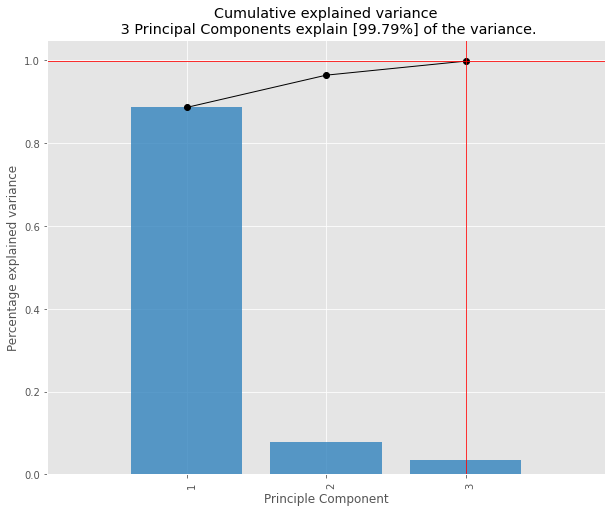

<Figure size 432x288 with 0 Axes>

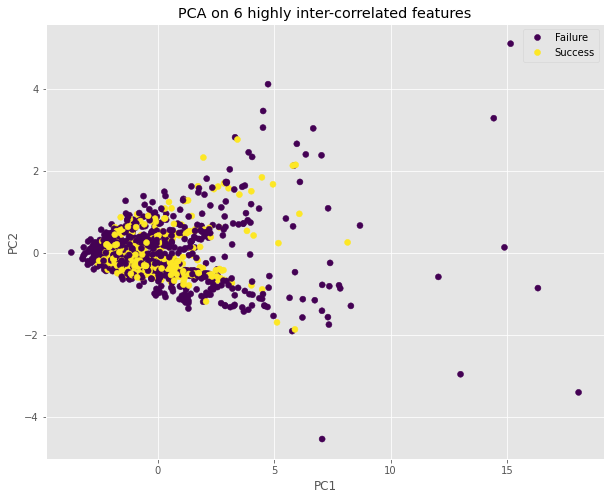

------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA']


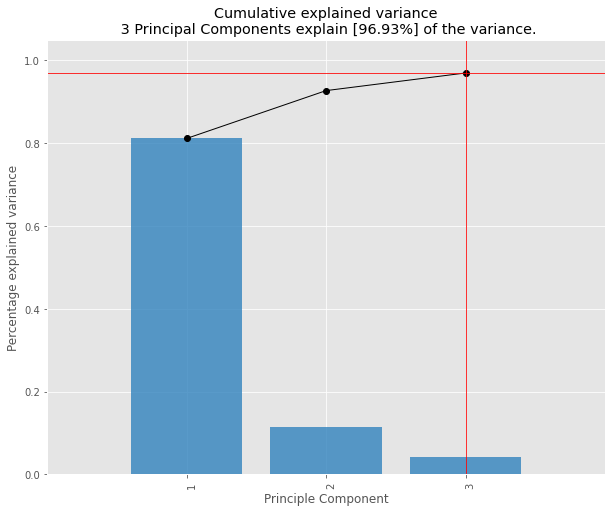

<Figure size 432x288 with 0 Axes>

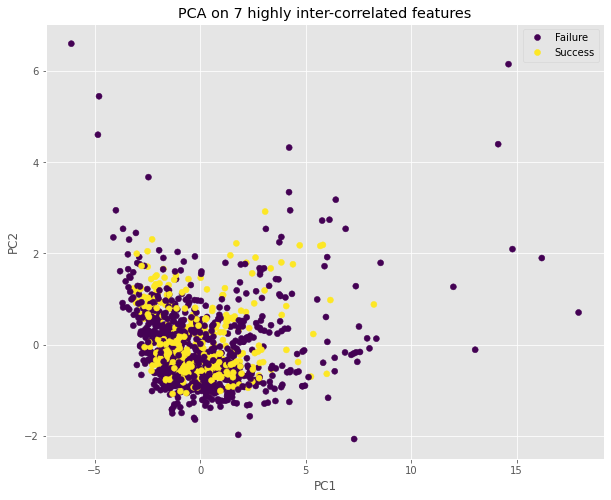

------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA', 'CC_HALF']


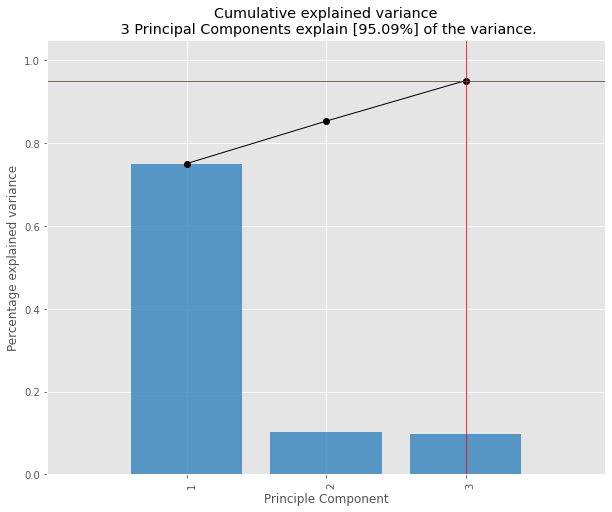

<Figure size 432x288 with 0 Axes>

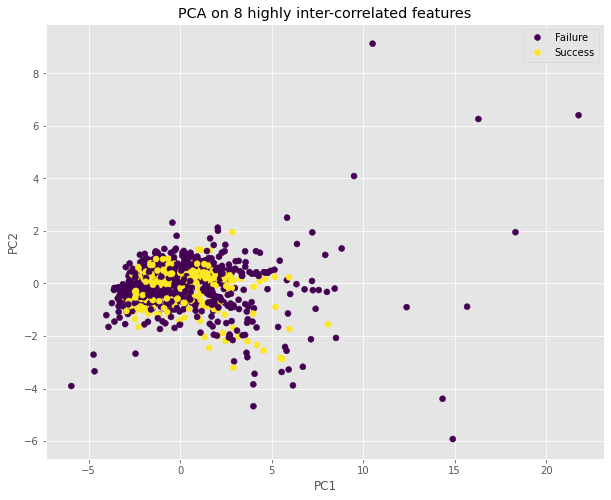

------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA', 'CC_HALF', 'DIFF_F']


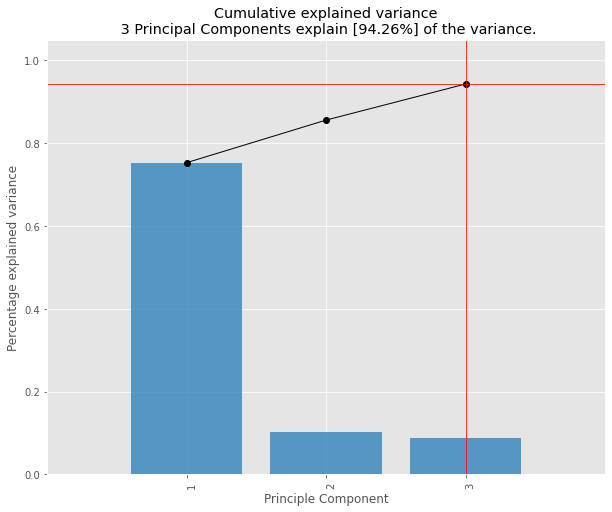

<Figure size 432x288 with 0 Axes>

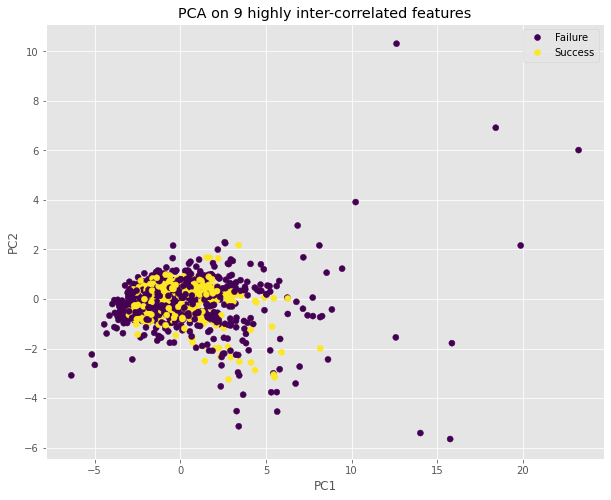

------------------------------------------------------------
3Dii
------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']


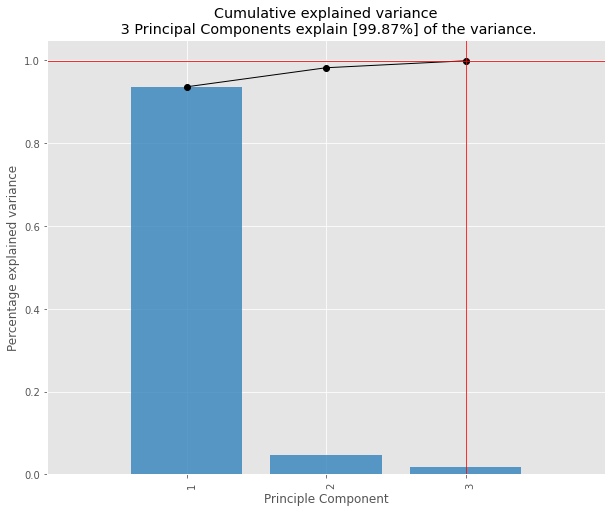

<Figure size 432x288 with 0 Axes>

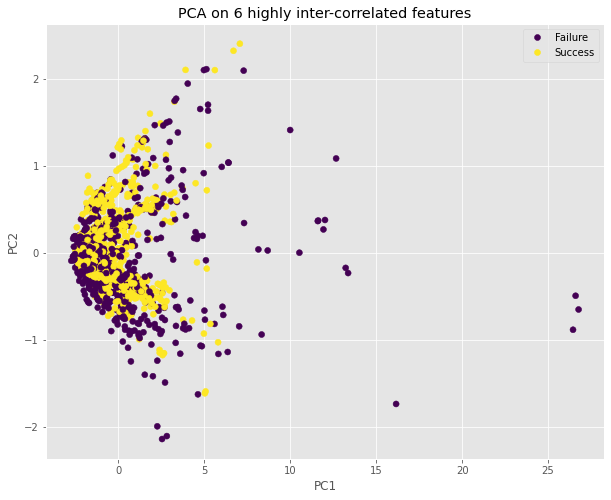

------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA']


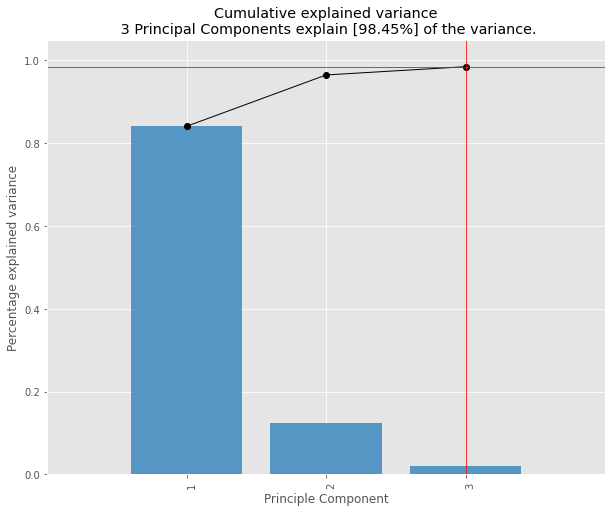

<Figure size 432x288 with 0 Axes>

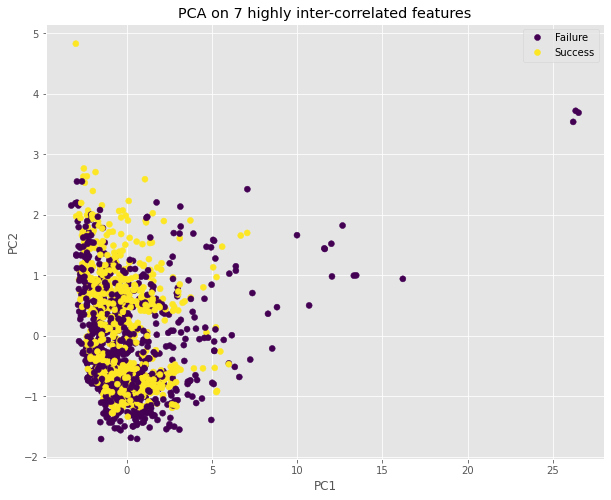

------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA', 'CC_HALF']


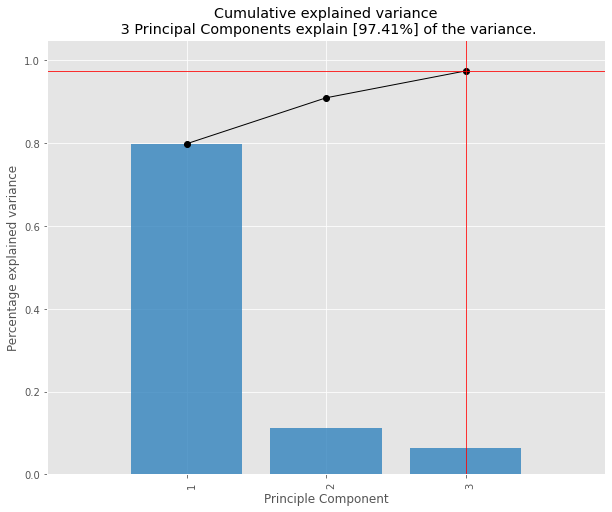

<Figure size 432x288 with 0 Axes>

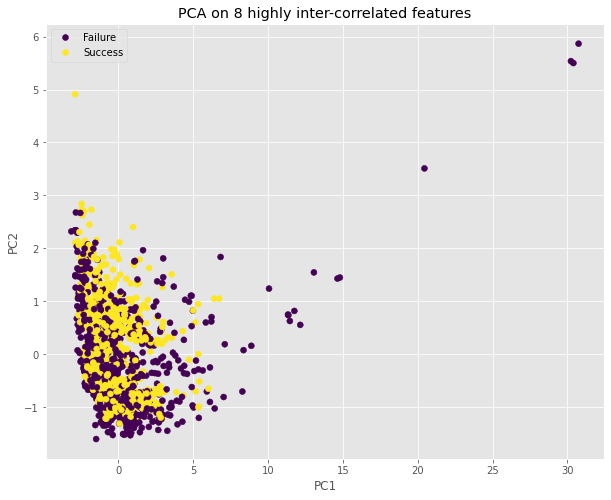

------------------------------
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA', 'CC_HALF', 'DIFF_F']


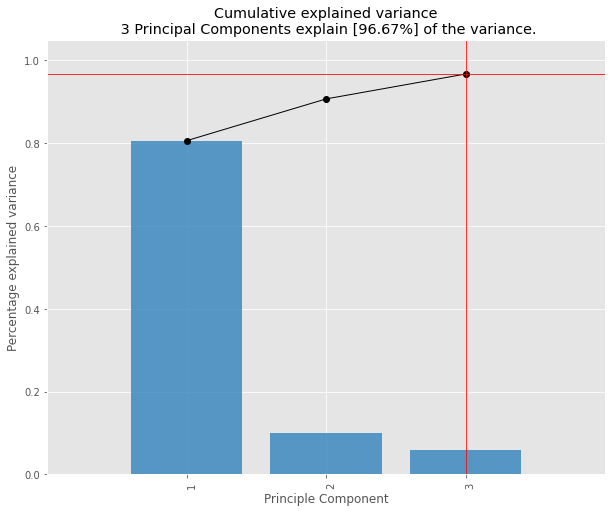

<Figure size 432x288 with 0 Axes>

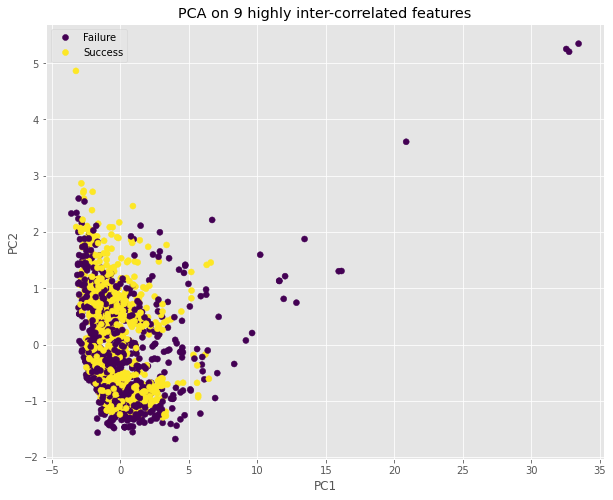

------------------------------------------------------------


In [2]:
from pca import pca


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y = datum.unpack(drop_col=["SPACEGROUP", "DATASET_id"])

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop("DATASET_NAME", axis=1)
    
    # get relevant features
    feat_names0 = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    feat_names1 = feat_names0 + ["I_SIGMA"]
    feat_names2 = feat_names1 + ["CC_HALF"]
    feat_names3 = feat_names2 + ["DIFF_F"]
    
    for feat_names in [feat_names0, feat_names1, feat_names2, feat_names3]:
        print("-"*30)
        print(">", feat_names)
        feats = x[feat_names]

        # fit pca
        model = pca(n_components=3, normalize=True, detect_outliers=None)
        results = model.fit_transform(feats, verbose=2)
        x_new = results["PC"]
        model.plot()

        # plot PC1 vs PC2
        fig, ax = plt.subplots(figsize=(10, 8))
        sct = ax.scatter(x_new.loc[:, "PC1"], x_new.loc[:, "PC2"], c=y)

        # labels
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_title(f"PCA on {len(feat_names)} highly inter-correlated features")
        ax.legend(sct.legend_elements()[0], ["Failure", "Success"])

        # show results
        plt.show()
    print("-"*60)

- **RMERGE_I, RMERGE_DIFF_I, RMEAS_I, RMEAS_DIFF_I, RPIM_I, RPIM_DIFF_I**

    PCA seems to work wonderfully in this feature group. Just 2 principal components represent 96/98% (DIALS/XDS) of the variance, and 3 PC's represent 99%, practically all of the variance.

    As such, **these 6 features can be safely represented by just 2 or 3 principal components** (or perhaps even just 1 for extra dimensionality reduction).


- All of the above + **I_SIGMA, CC_HALF, DIFF F**

    PCA is also very effective in this feature group. Now 3 principal components represent ~94/96% (DIALS/XDS) of the variance.
    
    Again, **these 9 features can be safely represented by just 3 principal components**, resulting in a reduction of 6 features/dimensions.
    
    
- Generally, DIALS and XDS are similarly effective, but the latter is slightly more so.

For clearer effect, try to see performance difference when these features are 'compacted'.

In [26]:
from read_data import data, np, pd, plt
from grouping import cluster_spacegroups
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations
from scipy.stats import sem, randint


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y, union = datum.unpack(drop_col=["DATASET_id", "RESOLUTION_HIGH", "RESOLUTION_LOW"], union=True)

    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)

    # get relevant features
    feat_names_base = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    '''feat_names1 = feat_names0 + ["I_SIGMA"]
    feat_names2 = feat_names1 + ["CC_HALF"]
    feat_names3 = feat_names2 + ["DIFF_F"]
    feat_names = [[], feat_names0, feat_names1, feat_names2, feat_names3]'''
    feat_names_extra = ["I_SIGMA", "CC_HALF", "DIFF_F"]

    cv, n_iter = 5, 50
    clf = Pipeline([("scaler", StandardScaler()), ("tree", DecisionTreeClassifier())])
    scores = cross_val_score(clf, x, y, scoring='f1', cv=cv, n_jobs=4)
    print(f"> NO PCA:\n F1 Score: {np.mean(scores):.2%} +- {sem(scores):.2%}")

    seed = 1
    for i in range(len(feat_names_extra) + 1):
        for feat_list in combinations(feat_names_extra, i):
            feat_list = feat_names_base + list(feat_list)
            print(">", feat_list)
            X = pd.DataFrame(StandardScaler().fit_transform(x), index=x.index, columns=x.columns)

            if feat_list:
                # create PCA columns
                X[["PC1", "PC2", "PC3"]] = PCA(n_components=3).fit_transform(X[feat_list])
                X = X.drop(feat_list, axis=1)

            # split train/test datasets
            #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

            # predict with decision tree
            #tree = DecisionTreeClassifier().fit(X_train, y_train)
            #y_pred = tree.predict(X_test)
            
            param_rand = {"class_weight": [None, "balanced"],
                  "criterion": ["gini", "entropy"], #metric to judge reduction of impurit
                  "max_features": randint(2, len(X_train.columns)+1), #max number of features when splitting
                  "min_samples_split": randint(2, 20+1), #min samples per node to induce split
                  "max_depth": randint(5, 20+1), #max number of splits to do
                  "min_samples_leaf": randint(1, 20+1), #min number of samples in a leaf; may set to 1 anyway
                  "max_leaf_nodes": randint(10, 40+1)} #max number of leaves
            
            # run randomized search
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=seed)
            scorer, n_iter = "f1", 50
            tree = DecisionTreeClassifier(random_state=seed)
            rand_search = RandomizedSearchCV(tree, param_rand, n_iter=n_iter, cv=5, scoring="f1", n_jobs=4, random_state=seed)
            rand_search.fit(X_train, y_train)
            
            # store scores
            scores = cross_val_score(rand_search.best_estimator_, X_test, y_test, scoring="f1", cv=cv, n_jobs=4)
            print(f"F1 Score: {np.mean(scores):.2%} +- {sem(scores):.2%}")

    print("-"*60)

Dials
> NO PCA:
 F1 Score: 64.28% +- 0.18%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']
F1 Score: 63.39% +- 3.49%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA']
F1 Score: 59.97% +- 3.15%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'CC_HALF']
F1 Score: 59.94% +- 4.36%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'DIFF_F']
F1 Score: 60.96% +- 4.99%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA', 'CC_HALF']
F1 Score: 64.37% +- 3.52%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGMA', 'DIFF_F']
F1 Score: 58.01% +- 2.21%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'CC_HALF', 'DIFF_F']
F1 Score: 61.35% +- 2.51%
> ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'I_SIGM

Generally, summarising these features using PCA leads to similar, even if more wildly behaved, scores. It then poses the question if they actually bring any insight into the model performance. Like was seen in the main notebook, **they can be safely removed**.